# Explore

### Imports

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

### Data Imports

In [231]:
df_track = pd.read_csv('data_clean/track.csv')
df_album = pd.read_csv('data_clean/album.csv')
df_artist = pd.read_csv('data_clean/artist.csv')
df = pd.read_csv('data_clean/rating.csv')
df_similar = pd.read_csv('data_clean/track_similarity.csv')

### Functions Definitions

In [232]:
def get_artist_id(artist_name):
    return df_artist[df_artist['name'] == artist_name]['artist_id'].values[0]

def get_album_id(album_name):
    return df_album[df_album['name'] == album_name]['album_id'].values[0]

def get_track_id(track_name):
    return df_track[df_track['name'] == track_name]['track_id'].values[0]

# ====================================================

def get_all_tracks_by_artist(artist_id, only_id=False):
    return df_track[df_track['artist_id'] == artist_id] if not only_id else df_track[df_track['artist_id'] == artist_id]['track_id']

def get_all_tracks_by_album(album_id, only_id=False):
    return df_track[df_track['album_id'] == album_id] if not only_id else df_track[df_track['album_id'] == album_id]['track_id']

def get_all_albums_by_artist(artist_id, only_id=False):
    return df_album[df_album['artist_id'] == artist_id] if not only_id else df_album[df_album['artist_id'] == artist_id]['album_id']

# ====================================================

def convert_track_id_to_name(track_id):
    return df_track[df_track['track_id'] == track_id]['title'].values[0]

def convert_album_id_to_name(album_id):
    return df_album[df_album['album_id'] == album_id]['name'].values[0]

def convert_artist_id_to_name(artist_id):
    return df_artist[df_artist['artist_id'] == artist_id]['name'].values[0]

# ====================================================

def compare_track_lists_sim(track_id_list_1, track_id_list_2):

    ret_list = []

    for main_track_id in track_id_list_1:
        for other_track_id in track_id_list_2:    
            
            similarity = df_similar[(df_similar['track_id_1'] == main_track_id) & (df_similar['track_id_2'] == other_track_id)]
            
            if not similarity.empty:
                name1 = convert_track_id_to_name(main_track_id)
                name2 = convert_track_id_to_name(other_track_id)
                ret_list.append((name1, name2, float(similarity.iloc[0]["sim_degree"])))

            similarity = df_similar[(df_similar['track_id_2'] == main_track_id) & (df_similar['track_id_1'] == other_track_id)]
            
            if not similarity.empty:
                name1 = convert_track_id_to_name(main_track_id)
                name2 = convert_track_id_to_name(other_track_id)
                ret_list.append((name1, name2, float(similarity.iloc[0]["sim_degree"])))

    ret = sorted(ret_list, key=lambda x: x[2], reverse=True)
    return ret

## Ranking Sources Comparision

In [233]:
def process_ratings():
    df = pd.read_csv('data_clean/rating.csv')

    # Convert the original 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract year and month, and set day as the first day of the month
    df['date'] = pd.to_datetime(df['date'].dt.strftime('%Y'))
    df['date'] = df['date'].dt.to_period('Y')

    print(df.shape)

    # Group by track_id and the modified date column (year-month) and calculate the mean
    df_new = (
        df.groupby(['track_id', 'date'], as_index=False)
        .mean(numeric_only=True)
        .round(0)
    )

    print(df_new.shape)

    # Compare the sparsity of the original and new data
    print('Original data sparsity:', df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))
    print('New data sparsity:', df_new.isnull().sum().sum() / (df_new.shape[0] * df_new.shape[1]))

    df = df_new
    df.head(10)

    return df

df = process_ratings()

(105511, 7)
(11756, 7)
Original data sparsity: 0.5011732019816485
New data sparsity: 0.4751616195985029


In [234]:
# Ensure rankings are numeric
columns_to_numeric = ['position_lastfm', 'position_spotify', 'position_billboard']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

df = df.drop(columns=['no_of_listeners_lastfm', 'no_of_listeners_spotify'])
df = df.dropna()

print('Rating dataframe shape:', df.shape)
print('Number of distinct tracks:', len(df['track_id'].unique()))

df.head(10)

Rating dataframe shape: (145, 5)
Number of distinct tracks: 127


,track_id,date,position_lastfm,position_spotify,position_billboard
4,3,2014,34.0,7.0,41.0
6,4,2014,45.0,17.0,55.0
8,5,2014,46.0,8.0,32.0
12,7,2014,66.0,11.0,32.0
16,9,2014,17.0,4.0,3.0
18,10,2014,33.0,10.0,9.0
20,11,2014,58.0,9.0,23.0
24,13,2014,47.0,16.0,17.0
28,15,2014,78.0,30.0,35.0
40,21,2014,27.0,6.0,21.0


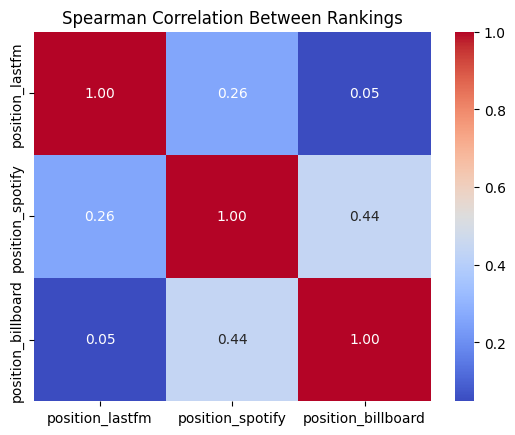

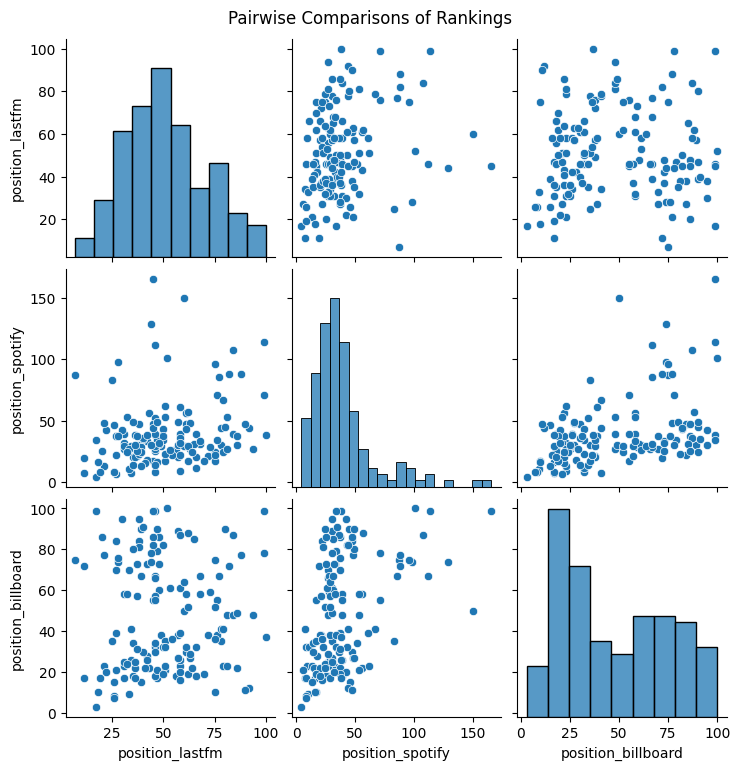

In [235]:
# Compute pairwise Spearman correlations
correlations = df[columns_to_numeric].corr(method='spearman')
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Between Rankings')
plt.show()

# Scatter plots to check for relationships
sns.pairplot(df, vars=columns_to_numeric)
plt.suptitle("Pairwise Comparisons of Rankings", y=1.02)
plt.show()

In [236]:
df = process_ratings()

# Ensure rankings are numeric
columns_to_numeric = ['no_of_listeners_lastfm', 'no_of_listeners_spotify']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

df = df.drop(columns=['position_lastfm', 'position_spotify', 'position_billboard'])
df = df.dropna()

print('Rating dataframe shape:', df.shape)
print('Number of distinct tracks:', len(df['track_id'].unique()))

df.head(10)

(105511, 7)
(11756, 7)
Original data sparsity: 0.5011732019816485
New data sparsity: 0.4751616195985029
Rating dataframe shape: (281, 4)
Number of distinct tracks: 247


,track_id,date,no_of_listeners_lastfm,no_of_listeners_spotify
4,3,2014,2774.0,2912855.0
6,4,2014,1787.0,2013722.0
8,5,2014,1927.0,2126197.0
12,7,2014,1599.0,1931628.0
16,9,2014,3419.0,3256386.0
18,10,2014,2406.0,2227387.0
20,11,2014,1821.0,2019324.0
24,13,2014,1653.0,1879094.0
28,15,2014,1616.0,1241468.0
40,21,2014,2496.0,2286016.0


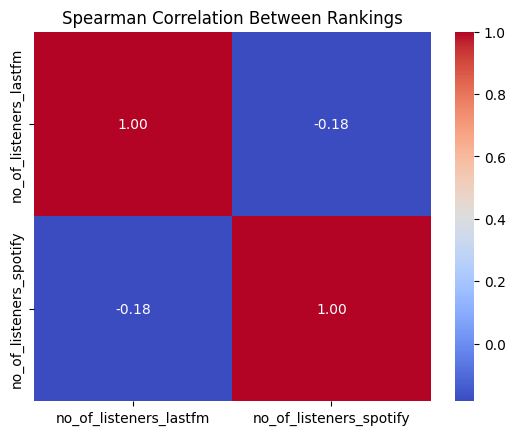

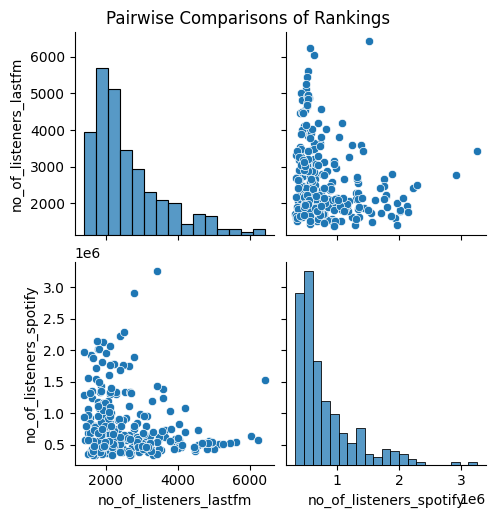

In [237]:
# Compute pairwise Spearman correlations
correlations = df[columns_to_numeric].corr(method='spearman')
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Between Rankings')
plt.show()

# Scatter plots to check for relationships
sns.pairplot(df, vars=columns_to_numeric)
plt.suptitle("Pairwise Comparisons of Rankings", y=1.02)
plt.show()